In [1]:
#패키지 선언
import tensorflow as tf
import tensorflow_hub as hub
#tensorflow-hub: 다양한 Pre-Trained 모델을 모듈(Module) 형태를 손쉽게 사용할 수 있고, Pre-Trained 모델을 내가 풀고자하는 문제에 Fine-Tuning해서 최소한의 노력으로 실제문제를 해결할 수 있음.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time
import os

In [2]:
#이미지 그리는 함수
def display_image(image):
    fig = plt.figure(figsize=(10, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

In [10]:
#이미지 박스 그려주는 함수
def draw_bounding_box_on_image(image, ymin, xmin, ymax,xmax, color, font, 
                               thickness=4,display_str_list=()):

# 이미지에 경계상자 그리기
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size #이미지 원사이즈
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)],width=thickness, fill=color)
    
# 이미지 상단에 글자넣기
# 만약 박스이미지가 이미지를 초과하면 하단에 글씨를 넣음.

    #display_str_list에 있는 text의 사이즈[1]를 가져와서 display_str_heights에 저장
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

    # 각각의 디스플레이마다 상단과 하단의 여백을 0.05로 설정함.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top

    else:
        text_bottom = bottom + total_display_str_height
        
    for display_str in display_str_list[::-1]:
        
        #font.getsize: text 사이즈를 가져옴.
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],fill=color)

        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,fill="black",font=font)

        text_bottom -= text_height - 2 * margin

In [11]:
#박스 그리기

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())

# 폰트 지정

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",25)

    except:
            print("Font not found, using default font.")
            
    font = ImageFont.load_default()



    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score: #최소의 값 이상인 값 찾기
            ymin, xmin, ymax, xmax = tuple(boxes[i]) #박스 좌표값 
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil,ymin,xmin,ymax,xmax,color,font,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))

    return image

In [12]:
#미리 학습된 모델인 inception_resnet_v2를 불러옴
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
# def load_img(path):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     return img

In [87]:
# def save_imgs(self): #내 컴퓨터에 사진저장
#     r, c = 5, 5
#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i,j].imshow(image_with_boxes[cnt, :,:,0], cmap='gray')
#             axs[i,j].axis('off')
#             cnt += 1
#         fig.savefig("C:/Users/jmlee/Desktop/Jimin/data_study/CNN_fruit/dataset/objection_detection_%d.png" % epoch)
#         plt.close()

In [92]:
import cv2
def run_detector(detector, path):
    for f in os.listdir(path):
        if f.split('.')[1] =='jpg':
            img = cv2.imread(path+'/'+f)
            img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    # 0~255 uint 자료형을 0 ~ 1 실수 자로형으로 변환한다.
            converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
            start_time = time.time()
            result = detector(converted_img)
            end_time = time.time()
            result = {key:value.numpy() for key,value in result.items()}
            print("이미지에서 찾은 %d개의 객체." % len(result["detection_scores"]))
            print("추론한 시간: ", end_time-start_time)
            image_with_boxes = draw_boxes(img, result["detection_boxes"],
                                  result["detection_class_entities"], result["detection_scores"])
            display_image(image_with_boxes)
#             save_imgs(image)

이미지에서 찾은 100개의 객체.
추론한 시간:  26.36251401901245
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  22.15477728843689
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  20.332646131515503
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  19.483914852142334
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  24.061687231063843
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  23.257826566696167
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  22.249522924423218
Font not found, using default font.


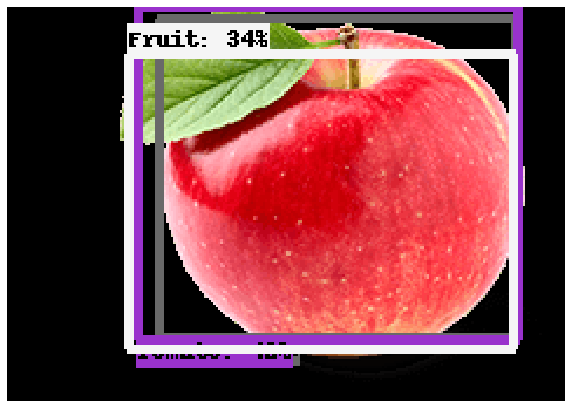

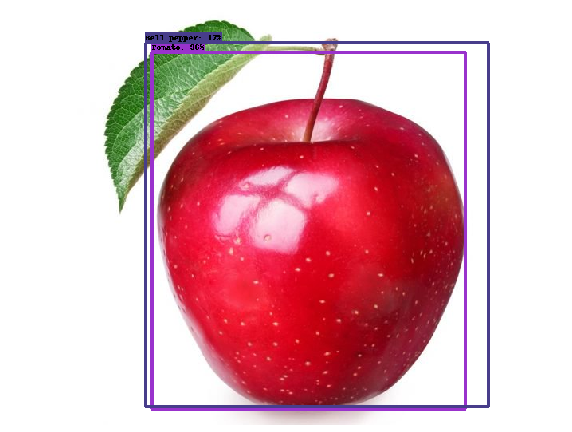

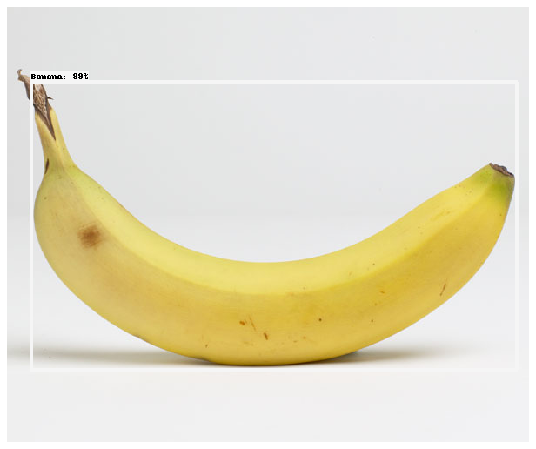

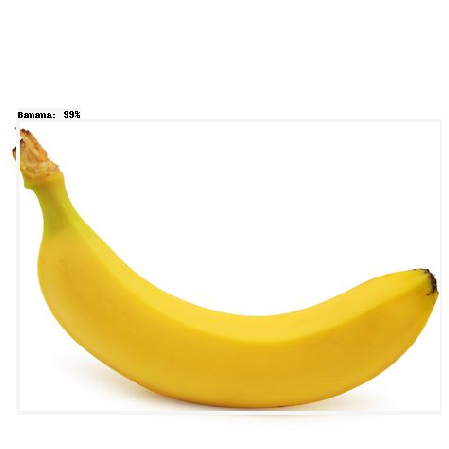

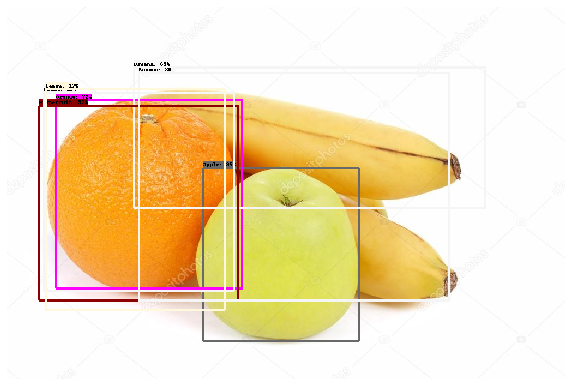

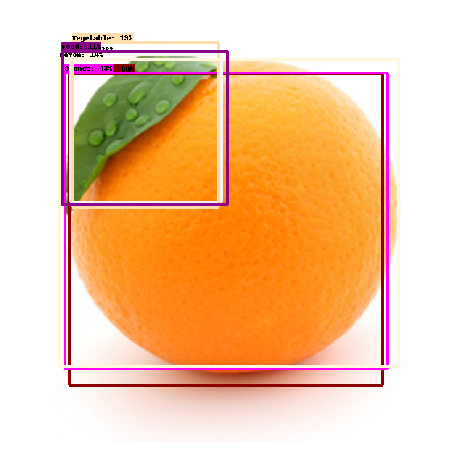

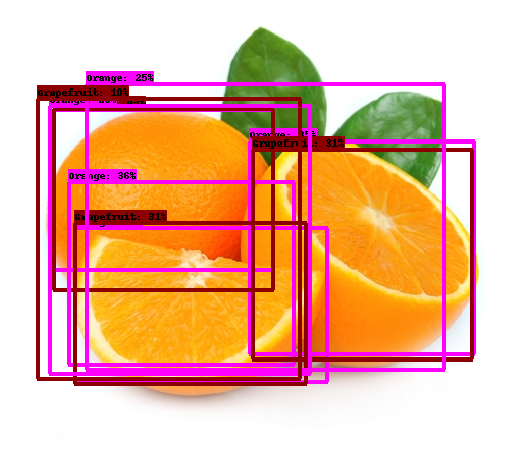

In [94]:
path ='C:/Users/jmlee/Desktop/Jimin/data_study/Objection_detection/dataset/sample'

# with open(path, 'r', encoding='utf-16') as f:
#     lines  = f.readlines()
run_detector(detector,path)
